In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
from astropy.io import fits
import numpy as np
from pyrafspec.fitslist import *
import matplotlib.pyplot as plt
from pyrafspec import splicing_spectrum
from pyrafspec.bfosclog import *
import pyrafspec.bfosce9g10 as bfosce9g10
import os
from astropy.time import Time
from astropy import constants, units
from PyAstronomy import pyasl
from astropy import coordinates as coord
from pyrafspec.spec_tools import rvcorr_spec
from pyrafspec.lighttraveltime import rv2baryrv
from laspec import normalization
import joblib
import collections
from astropy.table import Table
from tqdm import tqdm
plt.style.use('lijiaostyle')

In [24]:
wave = np.arange(10)
flux = wave
from astropy.table import Table
tab = Table(data=[wave, flux], names=['wave', 'flux'])
tab.write('test.fits')

In [25]:
lspec = fits.open('../data/spec-57304-EG025335S013827B01_sp05-169.fits.gz')

Text(0.5, 0, 'wavelength')

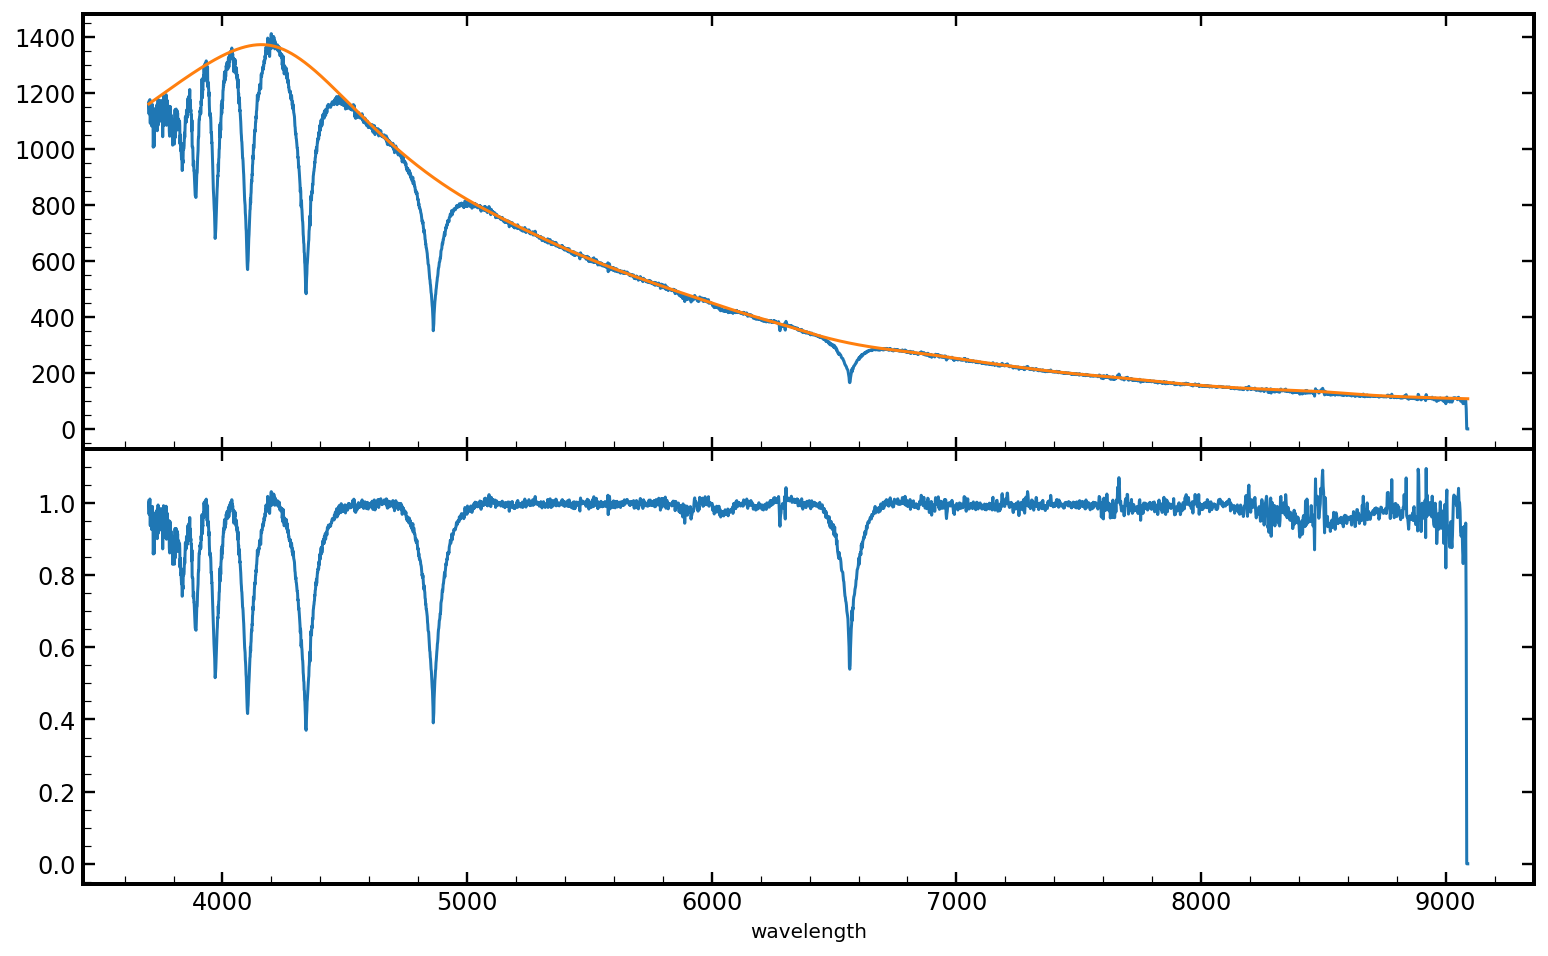

In [113]:
wave, flux0 = lspec[0].data[2], lspec[0].data[0]
wave = pyasl.vactoair2(wave)
fluxerr0 = np.sqrt(1/lspec[0].data[1])
flux, flux_conti = normalization.normalize_spectrum_spline(wave,flux0,p=1e-7, q=0.5, binwidth=1200, lu=(-0.2,50))
fluxerr = fluxerr0/flux_conti

fig,ax=plt.subplots(2,1, figsize=(13,8))
plt.subplots_adjust(hspace=0)
plt.sca(ax[0])
plt.plot(wave, flux0)
plt.plot(wave, flux_conti)
plt.sca(ax[1])
plt.plot(wave, flux)
plt.xlabel('wavelength')

# sersic fitting

lamost data


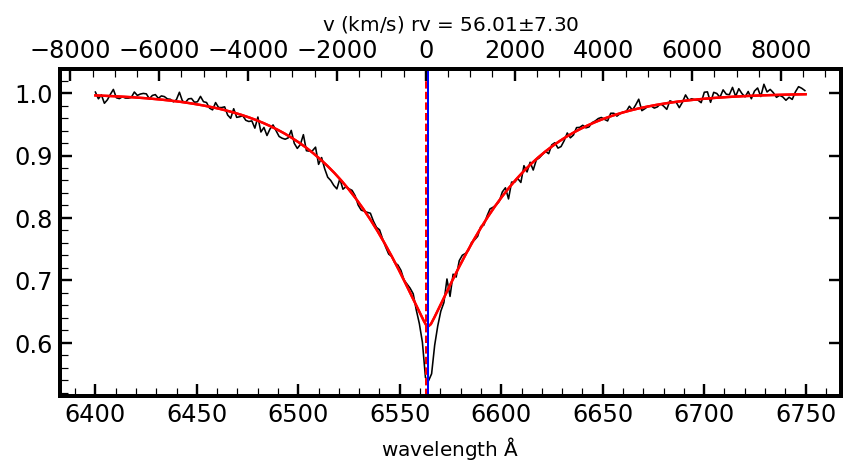

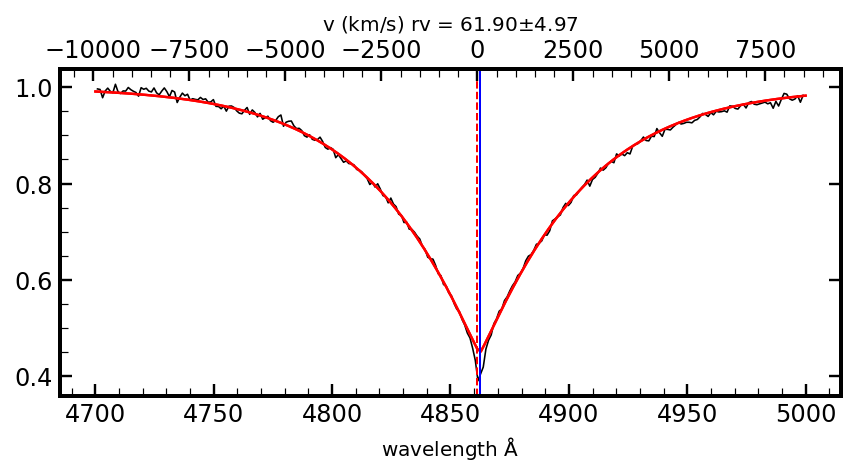

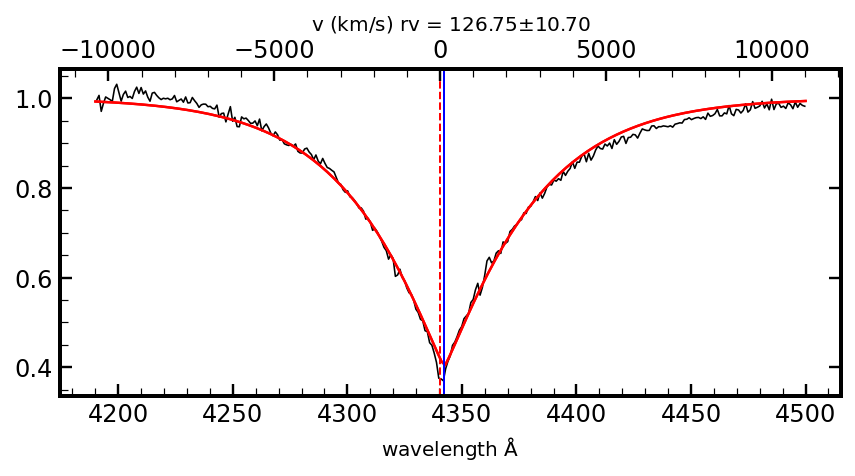

In [102]:
from PyAstronomy import pyasl
from pyrafspec.RVsersic import *
wvl = np.array([6562.79, 4861.35, 4340.46])

wvlVac = pyasl.airtovac2(wvl)
rv_halpha, rverr_halpha = rv_bysersic(wave, flux, lam0 = 6562.79, waverange = [6400, 6750], p0 = [0.8,4.,1.,6562.], show=True)  
rv_hbeta, rverr_hbeta = rv_bysersic(wave, flux, lam0=4861.35, waverange=[4700, 5000], p0=[0.6,4.5,0.8,4862.], show=True)
rv_hgamma, rverr_hgamma = rv_bysersic(wave, flux, lam0=4340.46, waverange = [4190, 4500], p0 = [0.8,4.,1.,4340.], show=True)
print('lamost data')

fake data


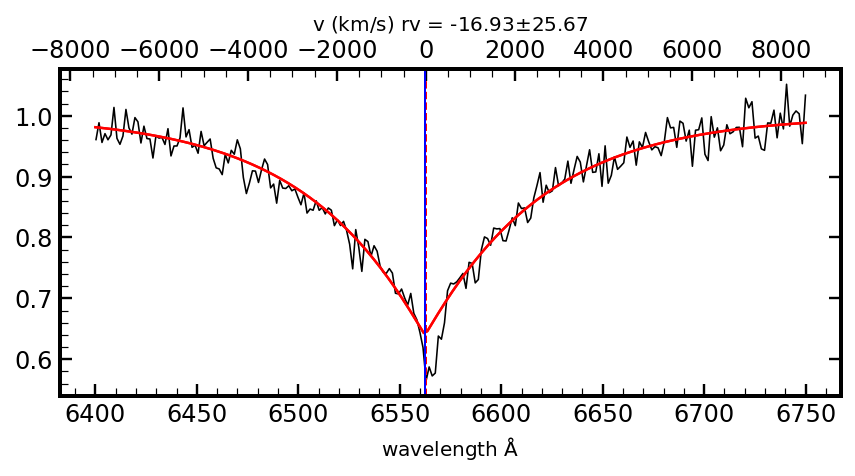

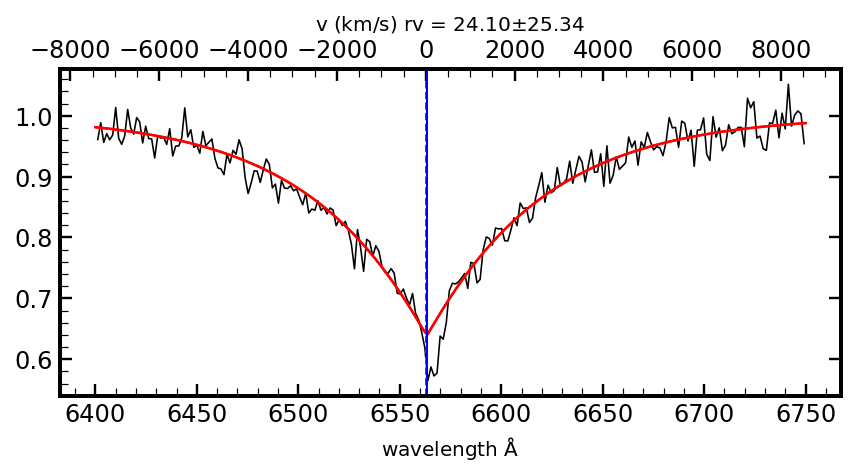

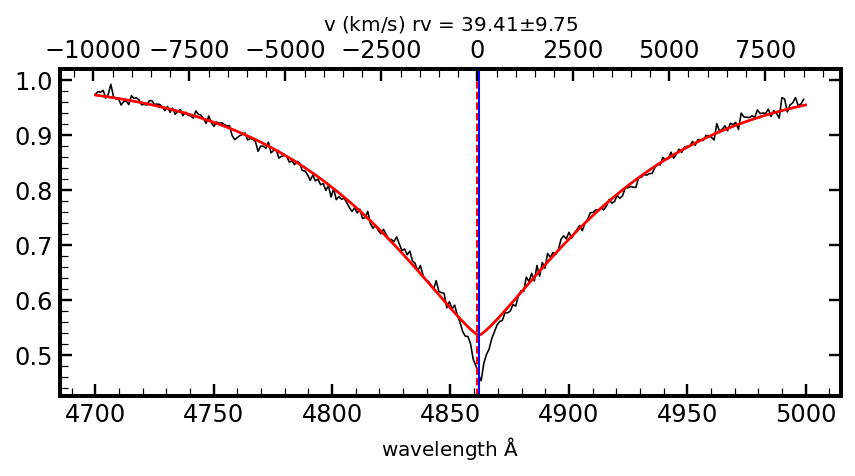

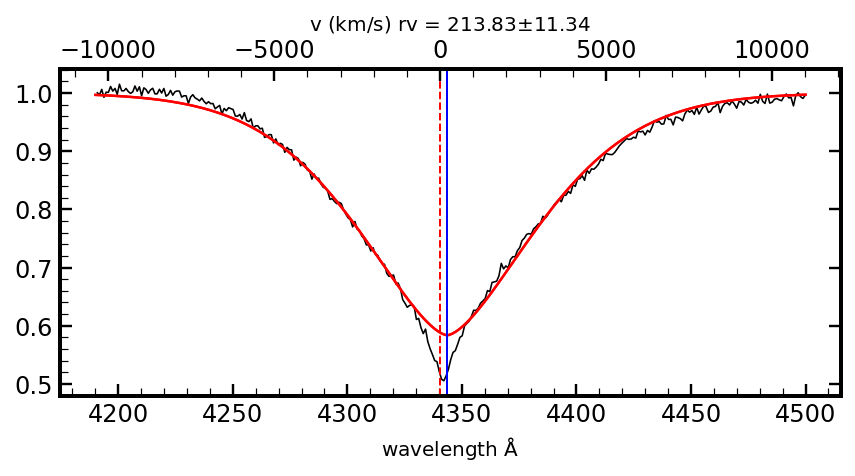

In [116]:
data2 = fits.getdata('../data/snr90test.fits')
wave2, flux2 = data2['wave'], data2['flux']
rv_halpha, rverr_halpha = rv_bysersic(wave2, flux2, lam0 = 6562.79, waverange = [6400, 6750], p0 = [0.8,4.,1.,6562.], show=True) 
rv_halpha, rverr_halpha = rv_bysersic(wave2, flux2, lam0 = 6562.79, waverange = [6400, 6750], p0 = [0.8,4.,1.,6562.], show=True, v = 40) 
rv_hbeta, rverr_hbeta = rv_bysersic(wave2, flux2, lam0=4861.35, waverange=[4700, 5000], p0=[0.6,4.5,0.8,4862.], show=True)
rv_hgamma, rverr_hgamma = rv_bysersic(wave2, flux2, lam0=4340.46, waverange = [4190, 4500], p0 = [0.8,4.,1.,4340.], show=True)
print('fake data')

In [112]:
rvm.pmod[:,1]

array([4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 ,
       4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25,
       4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75,
       4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 , 4.75, 4.25, 4.5 ,
       4.75, 4.25, 4.5 , 4.75])

@RVM: initializing Radial Velocity Machine (RVM)...
@RVM: calculating local variance ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done  22 out of  48 | elapsed:  1.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  27 out of  48 | elapsed:  1.4min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  32 out of  48 | elapsed:  1.5min remaining:   45.9s
[Parallel(n_jobs=-1)]: Done  37 out of  48 | elapsed:  1.6min remaining:   27.7s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:  1.6min remaining:   13.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.8min finished


(6500.0, 6700.0)

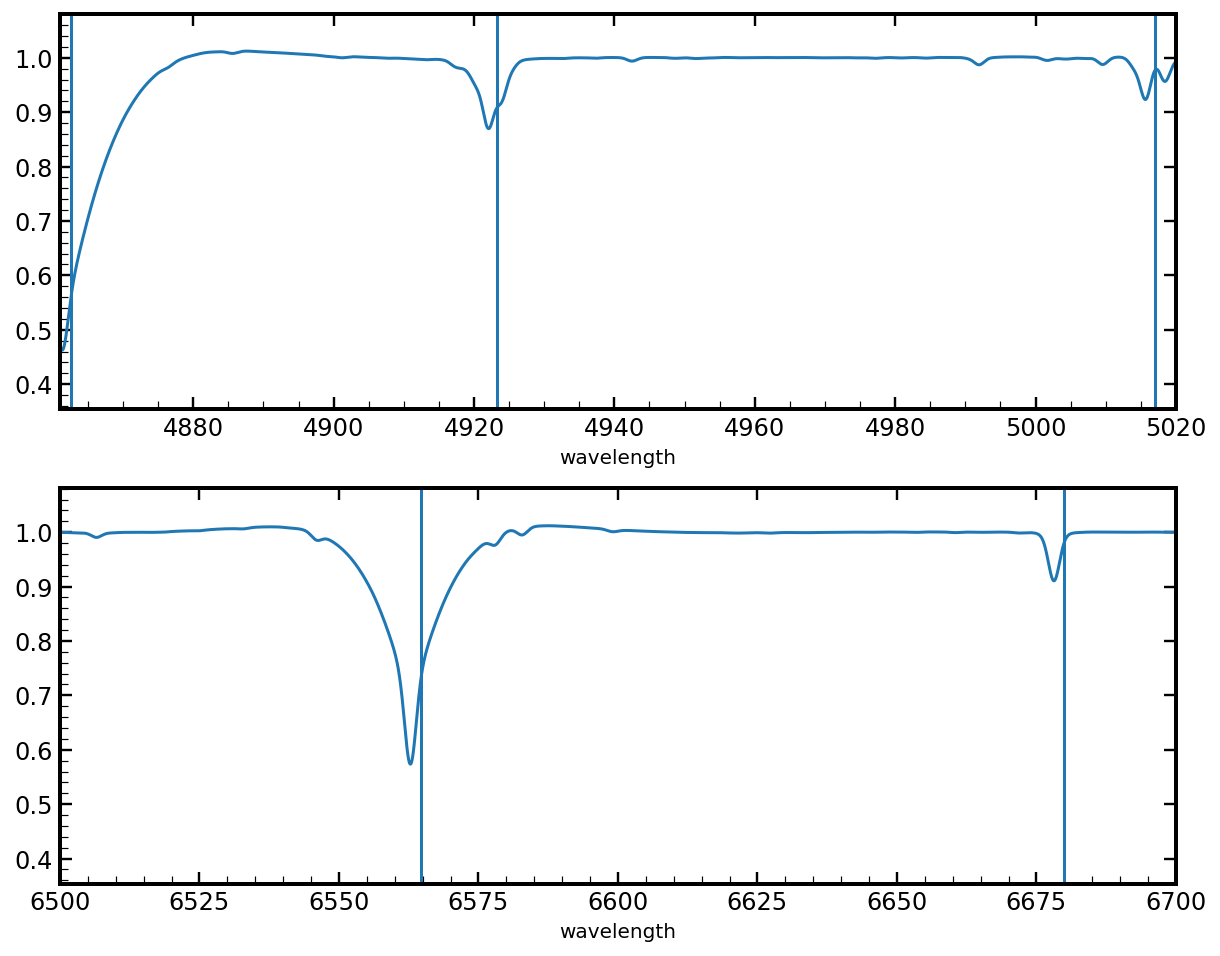

In [105]:
# laod and check radial velocity model
rvm = joblib.load('/media/share/lijiao/TLUSTY_grid/tlusty_for_bfosc_sdB_rv.dump')
from laspec.ccf import RVM
#_ind = (rvm.pmod[:,0] >= 27000) & (rvm.pmod[:,0] <= 31000)
#pmod_rv = rvm.pmod[_ind]
wavemod_rv = rvm.wave_mod
fluxmod_rv = rvm.flux_mod
rvm = RVM(rvm.pmod, wavemod_rv, fluxmod_rv, npix_lv=5)

### check rvm model wave is in vacuum or air
haVac = 6564.66464 # vacuum wavelength of Halpha
haAir = 6562.85175
heIAir = 6678.151
heIVac = 6679.995 # vacuum wavelength of HI
fig, axs = plt.subplots(2,1,figsize=[10,8])
plt.sca(axs[0])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=4862.6) #vacum
plt.axvline(x=4923.3)#vacuum
plt.axvline(x=5017.07)#vacuum
plt.xlabel('wavelength')
plt.xlim(4861, 5020)

plt.sca(axs[1])
plt.plot(rvm.wave_mod, rvm.flux_mod[0])
plt.axvline(x=haVac)
plt.axvline(x=heIVac)
plt.xlabel('wavelength')
plt.xlim(6500, 6700)

{'rv_opt': 60.0, 'rv_err': 1.0, 'rv_best': 60, 'ccfmax': 0.5176535832605353, 'success': True, 'imod': 2, 'pmod': array([1.50e+04, 4.75e+00, 1.00e+00, 1.00e+01, 0.00e+00]), 'status': 0, 'rv_pct': array([60., 60., 60.])}


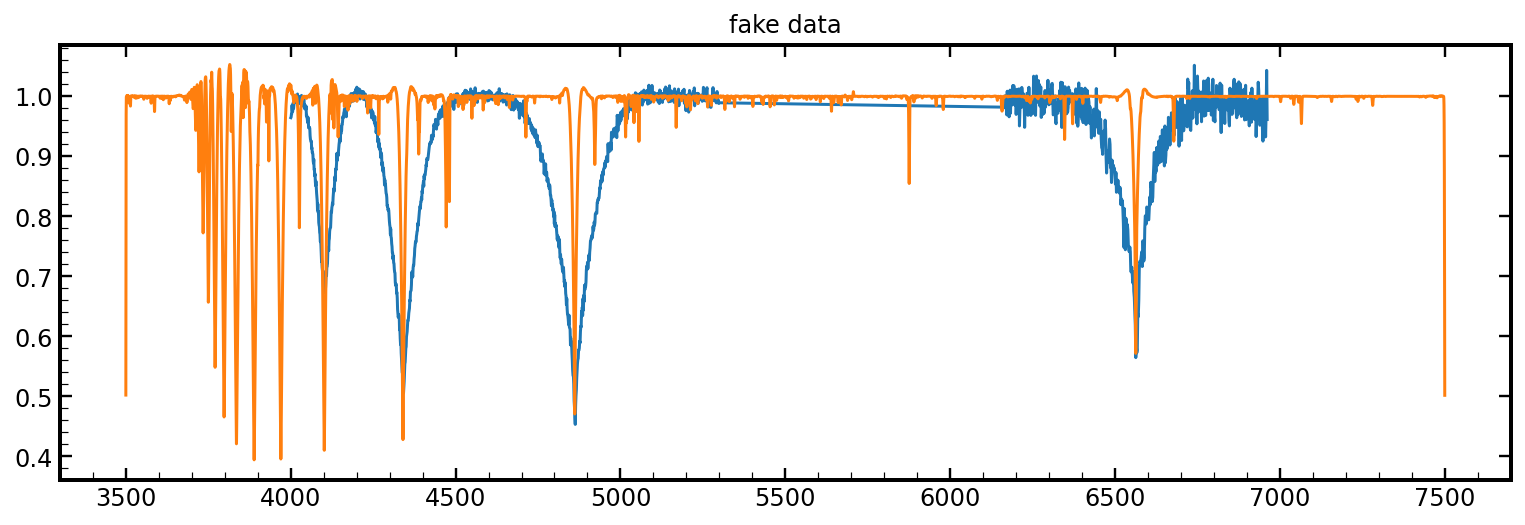

In [108]:
rvr = rvm.measure(wave2, flux2, flux_err=0.0111*np.ones(len(wave2)),  nmc=100, rv_grid=np.arange(-500, 500, 5),
                  )
fig,ax= plt.subplots(1,1,figsize=(13,4))
plt.plot(wave2, flux2)
plt.plot(rvm.wave_mod, rvm.flux_mod[rvr['imod']])
plt.title('fake data')
print(rvr)

{'rv_opt': 65.0, 'rv_err': 1.0, 'rv_best': 65, 'ccfmax': 0.038097871485382684, 'success': True, 'imod': 2, 'pmod': array([1.50e+04, 4.75e+00, 1.00e+00, 1.00e+01, 0.00e+00]), 'status': 0, 'rv_pct': array([65., 65., 65.])}


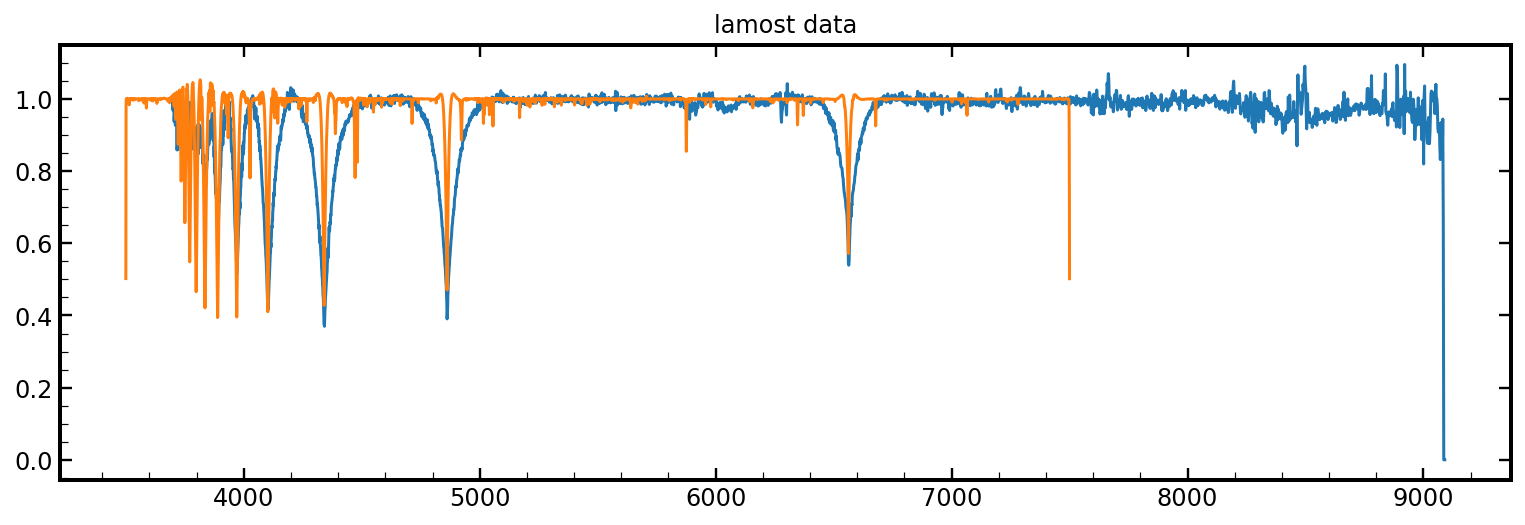

In [118]:
rvr = rvm.measure(wave, flux, flux_err=fluxerr,  nmc=100, rv_grid=np.arange(-500, 500, 5),
                  )
fig,ax= plt.subplots(1,1,figsize=(13,4))
plt.plot(wave, flux)
plt.plot(rvm.wave_mod, rvm.flux_mod[rvr['imod']])
plt.title('lamost data')

print(rvr)

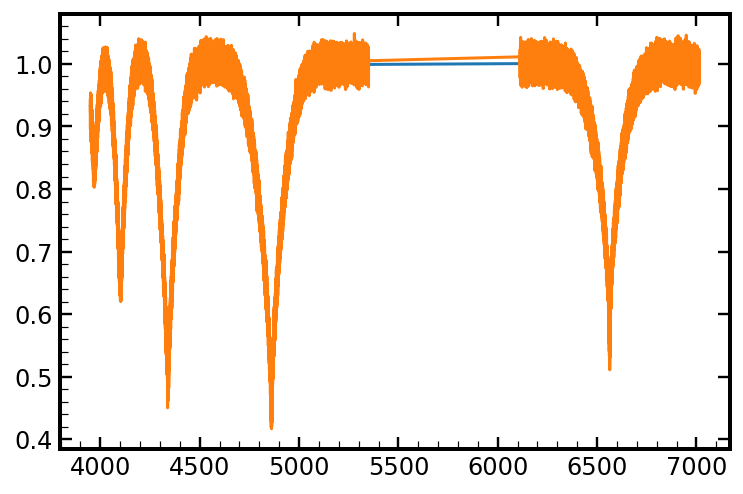

In [130]:
data_mod= fits.getdata('../data/snr90mod_test.fits')
wave_mod, flux_mod = data_mod['wave'], data_mod['flux']
plt.plot(wave_mod, flux_mod)
snr = 90
sigma = 1/snr
errs = np.random.normal(loc=0, scale = sigma, size = flux_mod.shape)
flux_1 = flux_mod+errs
errs = np.abs(errs)
plt.plot(wave_mod, flux_1)


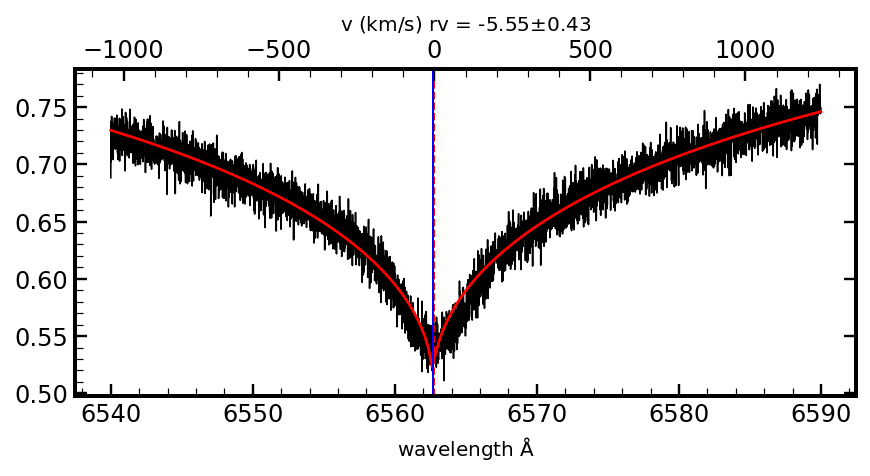

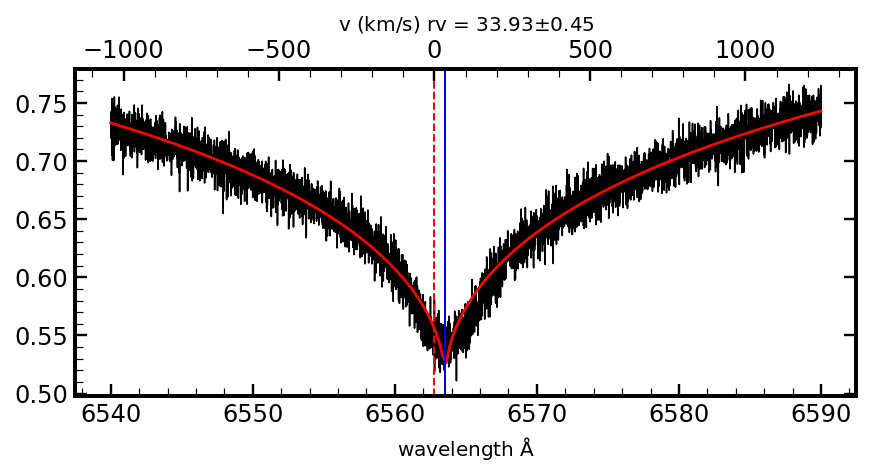

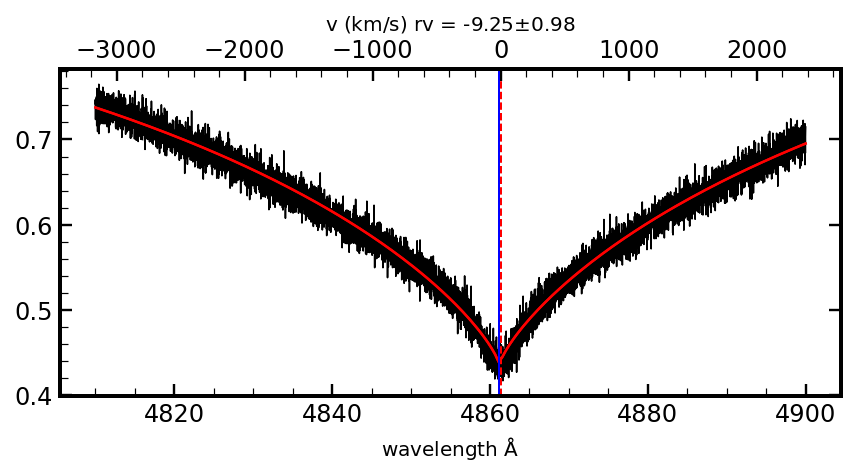

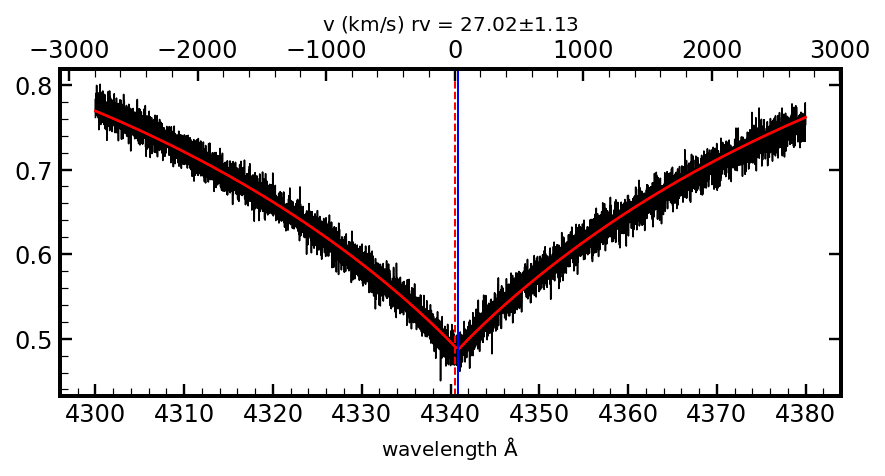

In [145]:
rv_halpha, rverr_halpha = rv_bysersic(wave_mod, flux_1, lam0 = 6562.79, waverange = [6540, 6590], p0 = [0.8,4.,1.,6562.], show=True) 
rv_halpha, rverr_halpha = rv_bysersic(wave_mod, flux_1, lam0 = 6562.79, waverange = [6540, 6590], p0 = [0.8,4.,1.,6562.], show=True, v = 40) 
rv_hbeta, rverr_hbeta = rv_bysersic(wave_mod, flux_1, lam0=4861.35, waverange=[4810, 4900], p0=[0.6,4.5,0.8,4862.], show=True)
rv_hgamma, rverr_hgamma = rv_bysersic(wave_mod, flux_1, lam0=4340.46, waverange = [4300, 4380], p0 = [0.8,4.,1.,4340.], show=True)

In [146]:
wave_lam, flux_lam = lspec[0].data[2], lspec[0].data[0]

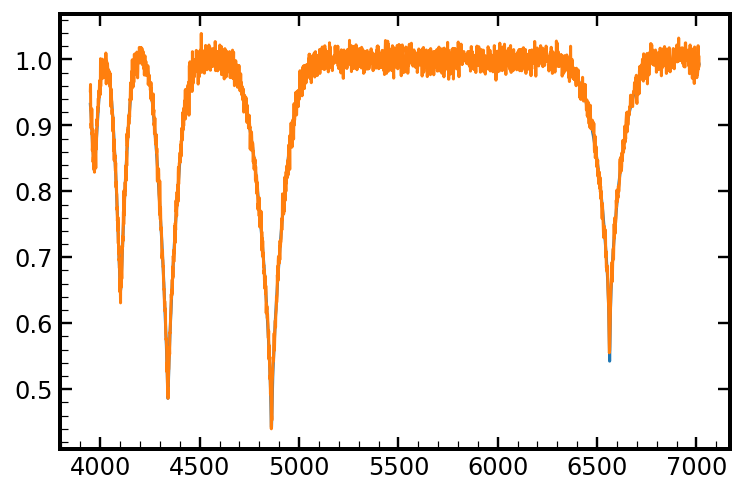

In [164]:
flux_mod_lam = np.interp(wave_lam, wave_mod, flux_mod, right=0, left=0)
_ind = flux_mod_lam > 0
errs = np.random.normal()
wave_mod_lam = wave_lam[_ind]
flux_mod_lam = flux_mod_lam[_ind]
snr = 90
flux_mod_lam1 = np.random.normal(flux_mod_lam, scale=1/snr)
errs = np.ones(len(flux_mod_lam)) * snr
plt.plot(wave_mod_lam, flux_mod_lam)
plt.plot(wave_mod_lam, flux_mod_lam1)

wave_mod_lam_rv = 10**rvcorr_spec(wave_mod_lam, flux_mod_lam, errs, 100, returnwvl=True)


(4300.0, 5000.0)

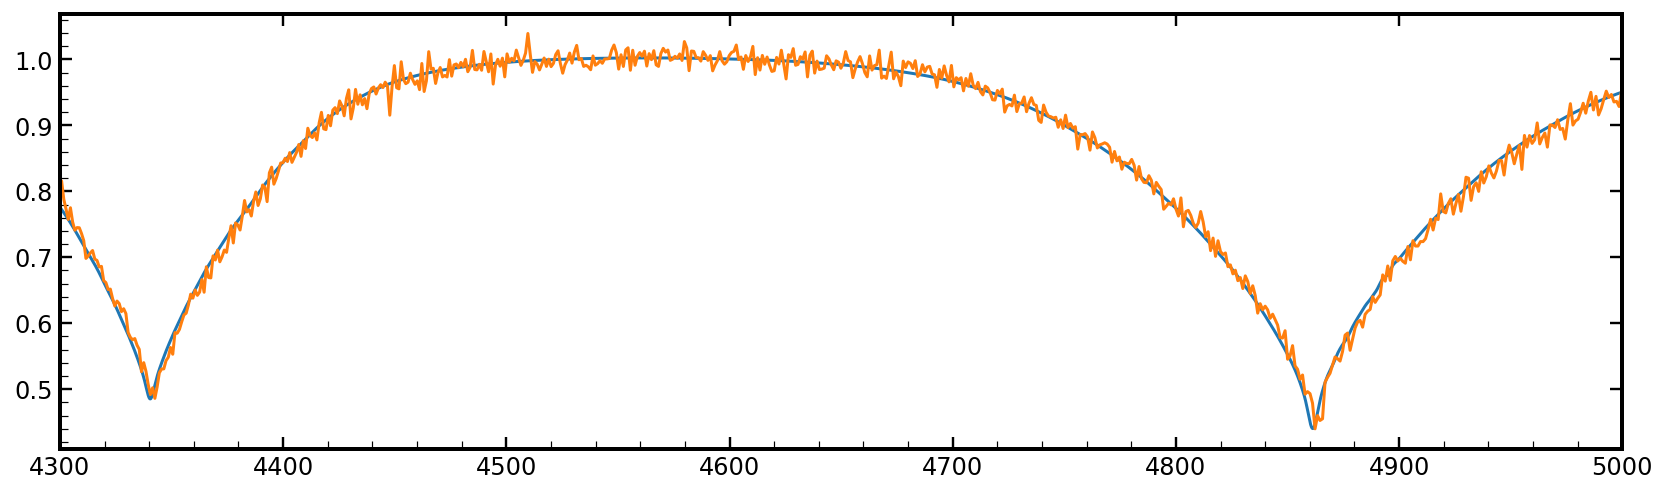

In [167]:
fig,ax=plt.subplots(1,1, figsize=[14,4])
plt.plot(wave_mod, flux_mod)
plt.plot(wave_mod_lam_rv, flux_mod_lam1 )
plt.xlim(4300, 5000)

In [168]:
rvm1 = RVM(rvm.pmod, wave_mod, flux_mod, npix_lv=5)

@RVM: initializing Radial Velocity Machine (RVM)...
@RVM: calculating local variance ...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.4s finished


In [173]:
rvr = rvm.measure(wave_mod_lam_rv, flux_mod_lam1, flux_err=errs,  nmc=100, rv_grid=np.arange(-500, 500, 5),
                  )

In [174]:
rvr

{'rv_opt': 90.0,
 'rv_err': 1.0,
 'rv_best': 90,
 'ccfmax': 0.4694506895833593,
 'success': True,
 'imod': 2,
 'pmod': array([1.50e+04, 4.75e+00, 1.00e+00, 1.00e+01, 0.00e+00]),
 'status': 0,
 'rv_pct': array([-31.04226707, 100.10908627, 324.31991322])}